## Group member: Yan Li, Yanwen Wang, Wenqi Wang, Yamin Zhao
 
**Date: May 2nd, 2022**


# 1. Introduction


The question we want to answer: Use the data to train an algorithm that predicts Superstore Sales

In today’s highly competitive and constantly changing business environment, the accurate and timely estimation of future sales, can offer critical knowledge to companies involved in the manufacturing, wholesale or retail of products.
Sales prediction is typically done arbitrarily by managers. However, skilled managers are hard to find and they are not always available (e.g. they may get sick or take a leave). Therefore, sales prediction should be supported by computer systems.One can exploit the wealth of sales data and related information to automatically construct accurate sales prediction models via machine learning techniques. This is a much simpler process, it is not biased from the particularities of a specific sales manager and it is dynamic, meaning it can adapt to changes in the data. Furthermore, it has the potential to outweigh the prediction accuracy of a human expert, who typically is imperfect.

Many previous studies have used time series to predict sales, especially in the absence of data, missing data and the presence of outliers. Sales can be considered as a time series. Different time series models have been developed, such as Holt-Winters, ARIMA, SARIMA, SARIMAX, GARCH, etc. However, it has also been argued that many exogenous factors that have an impact on sales are taken into account.Pavlyshenko(2019) states sales forecasting should be a regression problem rather than a time series problem. A popular approach nowadays is to use supervised machine learning methods to find complex patterns in sales dynamics. For example, tree-based machine learning algorithms, such as Random Forest, Gradiend Boosting Machine.However,we believe that the traditional time series is still meaningful.


# 2. Data

1. We are going to work with global superstore sales data that was collected form 2015 to 2019. The dataset can be easily find from Kaggle. 
2. We cleaned dataset, and retained dates, cities, and sales columns as our main object to study. We remove or eliminate not displayed (N/A) data in daily sales. 
3. Basically, we are going to process our data twice respectively. In the first time, we aggreage daily sales so that we can find the top-5 products. Secondly, we merged our sales according to the sells city. 
4. The comprehensive summary statistics follow with summary results.

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import datetime
import numpy as  np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn  import metrics
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv("train.csv", parse_dates=['Order Date'])

In [4]:
# Show all columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

There are many duplicates of the same order date. To be able to compare sales over time, we need to know the daily total of the sales. We sum all sales that were made on the same day.

In [5]:
# aggregate all entries with the same order date
dfDailySales = pd.DataFrame(df.groupby('Order Date')['Sales'].sum())

dfDailySales

,Sales
Order Date,
2015-01-02,468.9000
2015-01-03,2203.1510
2015-01-04,119.8880
2015-01-06,5188.5200
2015-01-07,601.0240
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


We will look into some popular products that are frequently bought by customers.

Top Sub-Categories by Number of Sales:

In [6]:
bestCategory = df['Sub-Category'].value_counts()
bestCategory

Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: Sub-Category, dtype: int64

Top Sub-Categories by Amount of Sales:

(The best-selling categories do not necessarily make them the most profitable)

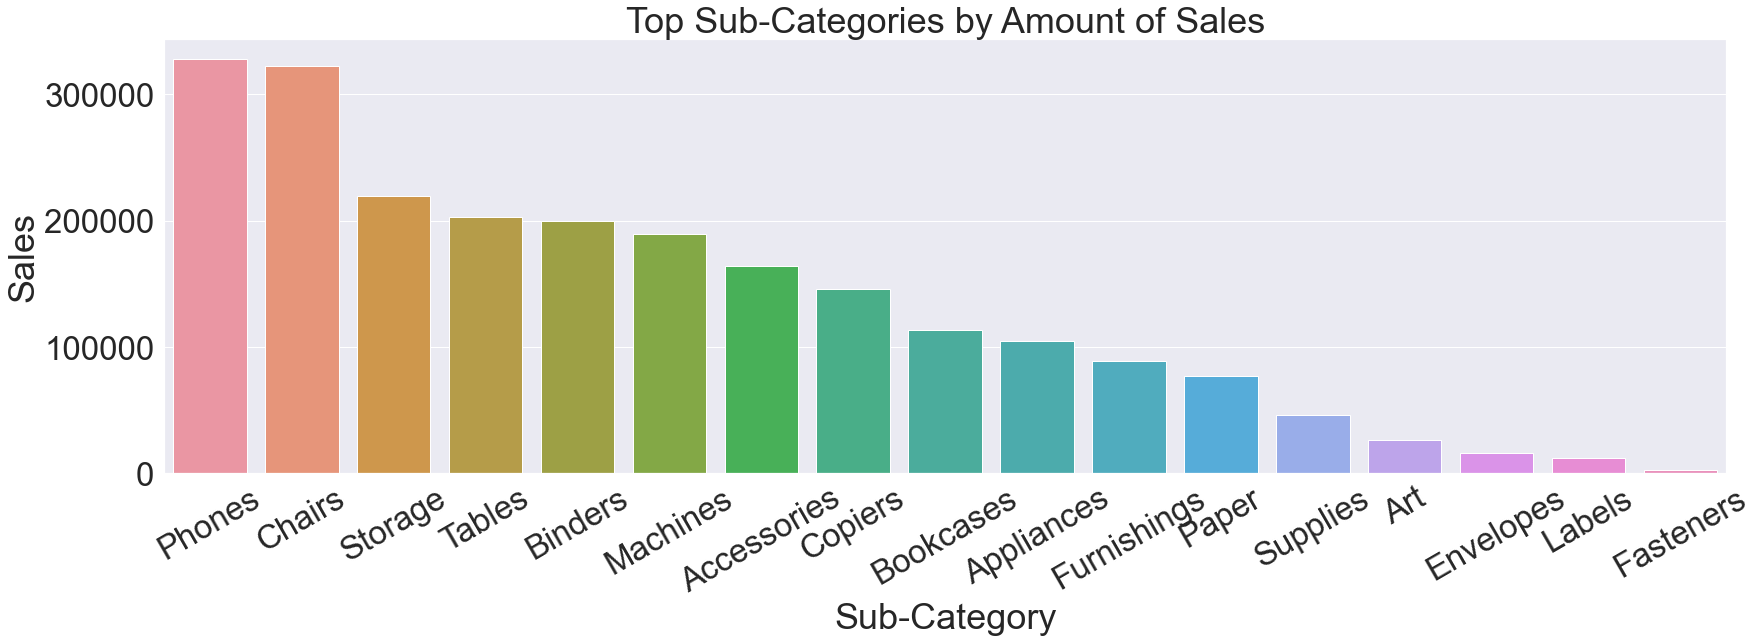

In [7]:
highestCategory = df.groupby(df["Sub-Category"]).sum()['Sales'].reset_index()
highestCategory = highestCategory.sort_values("Sales", ascending = False)

sns.set(font_scale=3)
plt.figure(figsize=(28,8));
plt.xticks(rotation=30)
plt.title('Top Sub-Categories by Amount of Sales')
sns.set_style('darkgrid')
sns.barplot(x='Sub-Category', y='Sales',data = highestCategory);

In [8]:
bestCity = df['City'].value_counts().head(25)
bestCity

New York City    891
Los Angeles      728
Philadelphia     532
San Francisco    500
Seattle          426
Houston          374
Chicago          308
Columbus         221
San Diego        170
Springfield      161
Dallas           156
Jacksonville     125
Detroit          115
Newark            92
Jackson           82
Columbia          81
Richmond          81
Aurora            68
Phoenix           63
Arlington         60
San Antonio       59
Miami             56
Louisville        54
Rochester         53
Long Beach        52
Name: City, dtype: int64

Top 25 cities that have generated the highest amount of sales:

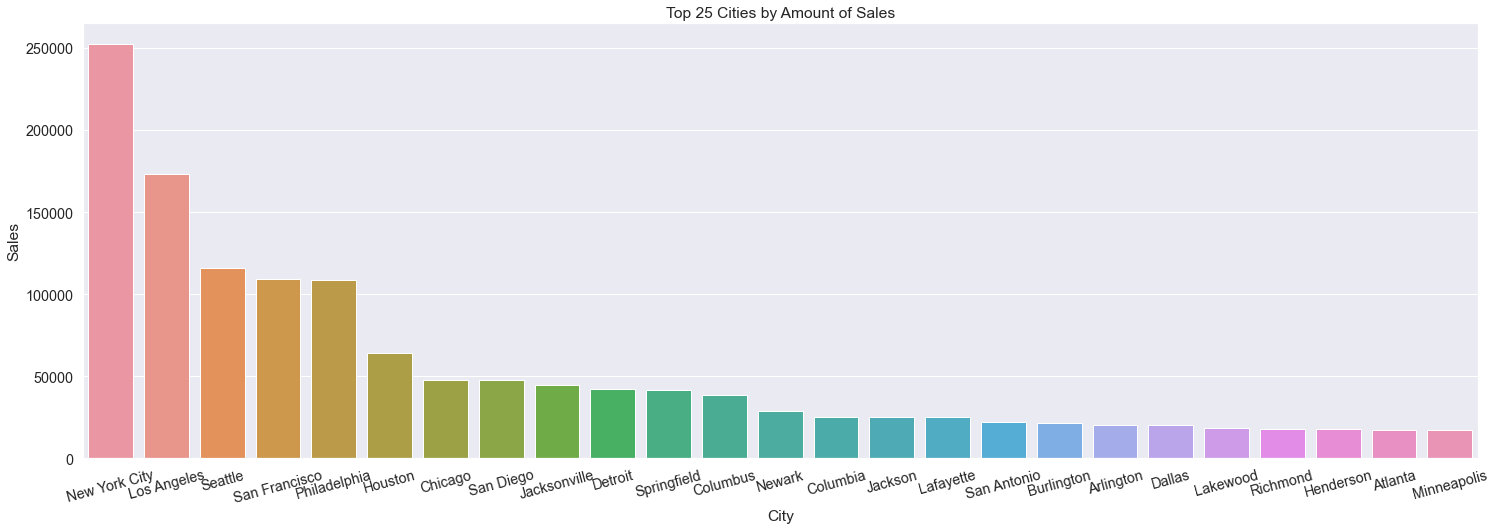

In [9]:
highestCities = pd.DataFrame(df.groupby(df['City']).sum()['Sales']).reset_index()
highestCities = highestCities.sort_values("Sales", ascending = False)

sns.set(font_scale=1.3)
plt.figure(figsize=(25,8));
plt.xticks(rotation=15)
plt.title('Top 25 Cities by Amount of Sales')
sns.set_style('darkgrid')
sns.barplot(x='City', y='Sales',data = highestCities.head(25));

We wanted to visually represent trends, cycles and seasonal behavior, so we used line charts:

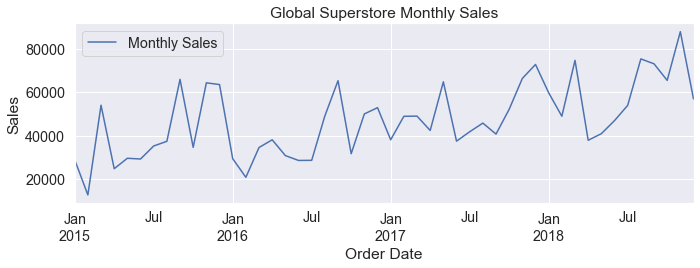

In [10]:
# resample data with the sum of monthly sales
plt.figure(figsize=(10, 4))
dfDailySales['Sales'].resample("M").sum().plot(label='Monthly Sales')
plt.title("Global Superstore Monthly Sales")
plt.legend(loc="best")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

There is a positive trend in our numbers. Over the four years, sales grew slowly. A spike in data develops during the holidays.

Visualization:

/var/folders/5s/m0glhfbn1ms3tcl2wxfj59_40000gn/T/ipykernel_6076/1566684769.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


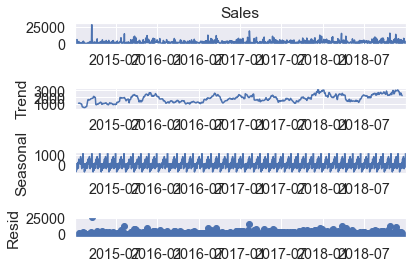

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition using multiplicative decomposition.
tseries = seasonal_decompose(dfDailySales['Sales'], model='additive', period=30)
tseries.plot();
sns.set(font_scale=4)

plt.tight_layout()
plt.show()

As shown in the visualization,the seasonality is more apparent when data is decomposed.

Using a correlation heatmap, we can identify time step atrributes that are correlated to the target variable. Becuase of the nature of retail businesses, Superstore's sales depend highly on its seasonality. Shifting short periods of time (1-14 days) will not reveal much correlation. Therefore, I have looked into long term time shifts such as a month (30 days), and a quarter (120 days).

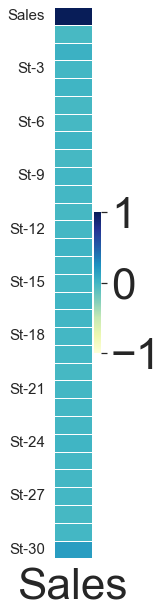

In [12]:
##################################################################
# CONFIGURATION SECTION
NUM_TIME_STEPS  = 30
##################################################################

# Creates time shifted columns for as many time steps needed.
def backShiftColumns(df, originalColName, numTimeSteps):
    dfNew  = df[[originalColName]].pct_change()

    for i in range(1, numTimeSteps + 1):
        newColName       = originalColName[0] + 't-' + str(i)
        dfNew[newColName]= dfNew[originalColName].shift(periods=i)
    return dfNew

def prepareDf(df, columns):

    # Create data frame with back shift columns for all features of interest.
    mergedDf = pd.DataFrame()
    for i in range(0, len(columns)):
        backShiftedDf  = backShiftColumns(df, columns[i], NUM_TIME_STEPS)
        if(i==0):
            mergedDf = backShiftedDf
        else:
            mergedDf = mergedDf.merge(backShiftedDf, left_index=True,
                       right_index=True)

    return mergedDf

columns = ["Sales"]
dfSales = prepareDf(dfDailySales, columns)
dfSales.dropna(inplace=True)

import seaborn as sns

corr = dfSales.corr()
plt.figure(figsize = (4,10))
ax = sns.heatmap(corr[['Sales']],vmin=-1, linewidth=0.8, vmax=1, cmap="YlGnBu")
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

As we expected, with 30-day shift, there is not much correlation found between time step attributes and Sales.

/var/folders/5s/m0glhfbn1ms3tcl2wxfj59_40000gn/T/ipykernel_6076/468225667.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfNew[newColName]= dfNew[originalColName].shift(periods=i)


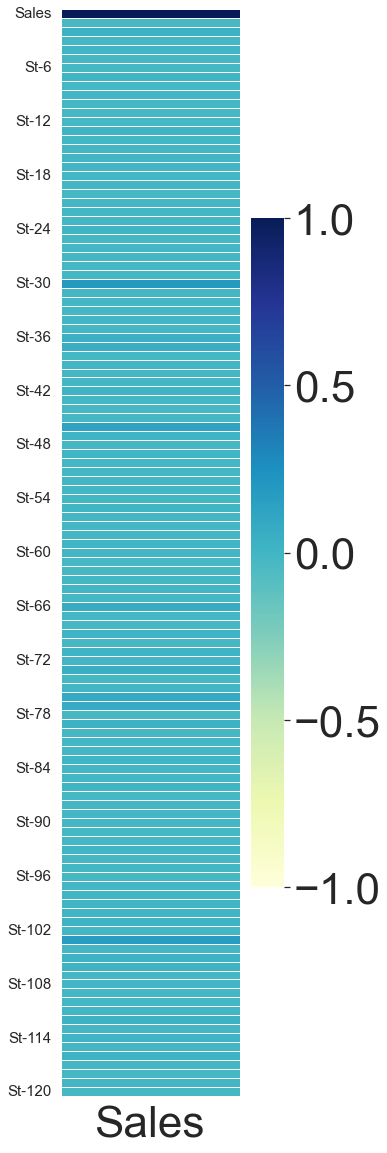

In [13]:
##################################################################
# CONFIGURATION SECTION
NUM_TIME_STEPS  = 120
##################################################################
dfSales = prepareDf(dfDailySales, columns)
dfSales.dropna(inplace=True)

import seaborn as sns

corr = dfSales.corr()
plt.figure(figsize = (4,20))
ax = sns.heatmap(corr[['Sales']],
            linewidth=0.5, vmin=-1,
            vmax=1, cmap="YlGnBu")
plt.yticks(fontsize=15)

plt.show()

Again, even with 120 days back, not many meaningful correlations are present; however, we can see occasional darker spots around t-30, t-76 and t-103.

# 3. Model 

Using 60 time steps as our back-shifting (training) data, and we through it to test or valid 30 most recent observations.15 of them are for testing and the other 15 are for validation of the our final model

In [14]:
##################################################################
NUM_TIME_STEPS  = 60
TEST_DAYS       = 30    # for test and validation
EVAL_DAYS       = 15    # 15 for testing and the other 15 for validation for the stacked model.
##################################################################

## First model is OLS

We are shifting columns to create time steps that will be used as predictor variables.

In [15]:
# Creates time shifted columns for as many time steps needed.
def backShiftColumns(df, originalColName, numTimeSteps):
    dfNew  = df[[originalColName]]

    for i in range(1, numTimeSteps + 1):
        newColName       = originalColName[0] + 't-' + str(i)
        dfNew[newColName]= dfNew[originalColName].shift(periods=i)
    return dfNew

def prepareDf(df, columns):

    # Create data frame with back shift columns for all features of interest.
    mergedDf = pd.DataFrame()
    for i in range(0, len(columns)):
        backShiftedDf  = backShiftColumns(df, columns[i], NUM_TIME_STEPS)
        if(i==0):
            mergedDf = backShiftedDf
        else:
            mergedDf = mergedDf.merge(backShiftedDf, left_index=True,
                       right_index=True)

    return mergedDf


In [16]:
columns = ["Sales"]
dfSales = prepareDf(dfDailySales, columns)
dfSales.dropna(inplace=True)
sigFeaturesLi = ["St-25", "St-33", "St-46", "St-60"]

# Split X and y
X = dfSales.copy()
X = X[sigFeaturesLi]
y = dfSales["Sales"]

# Add intercept for OLS regression.
X = sm.add_constant(X)

/Users/wangyanwen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Splitting Test and Train sets

In [17]:
# Split into test and train sets. The test data must be the latest data range.
lenData = len(X)
X_train = X[0:lenData-TEST_DAYS]
y_train = y[0:lenData-TEST_DAYS]
X_test  = X[lenData-TEST_DAYS:lenData-EVAL_DAYS]    # 15 for testing
y_test  = y[lenData-TEST_DAYS:lenData-EVAL_DAYS]
stack_X_test = X[lenData-EVAL_DAYS:]        # 15 for stacked evaluation
stack_y_test = y[lenData-EVAL_DAYS:]

In [18]:
# Fit the model
olsModel = sm.OLS(y_train, X_train).fit()
print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.536
Date:                Fri, 06 May 2022   Prob (F-statistic):           8.71e-07
Time:                        11:41:55   Log-Likelihood:                -10372.
No. Observations:                1140   AIC:                         2.075e+04
Df Residuals:                    1135   BIC:                         2.078e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1274.6576    119.516     10.665      0.0

## Second Model is SARIMA

### Seasonal Differencing
In this section, we deal with seasonal patterns using different techniques and then show the visual representation of outcomes.

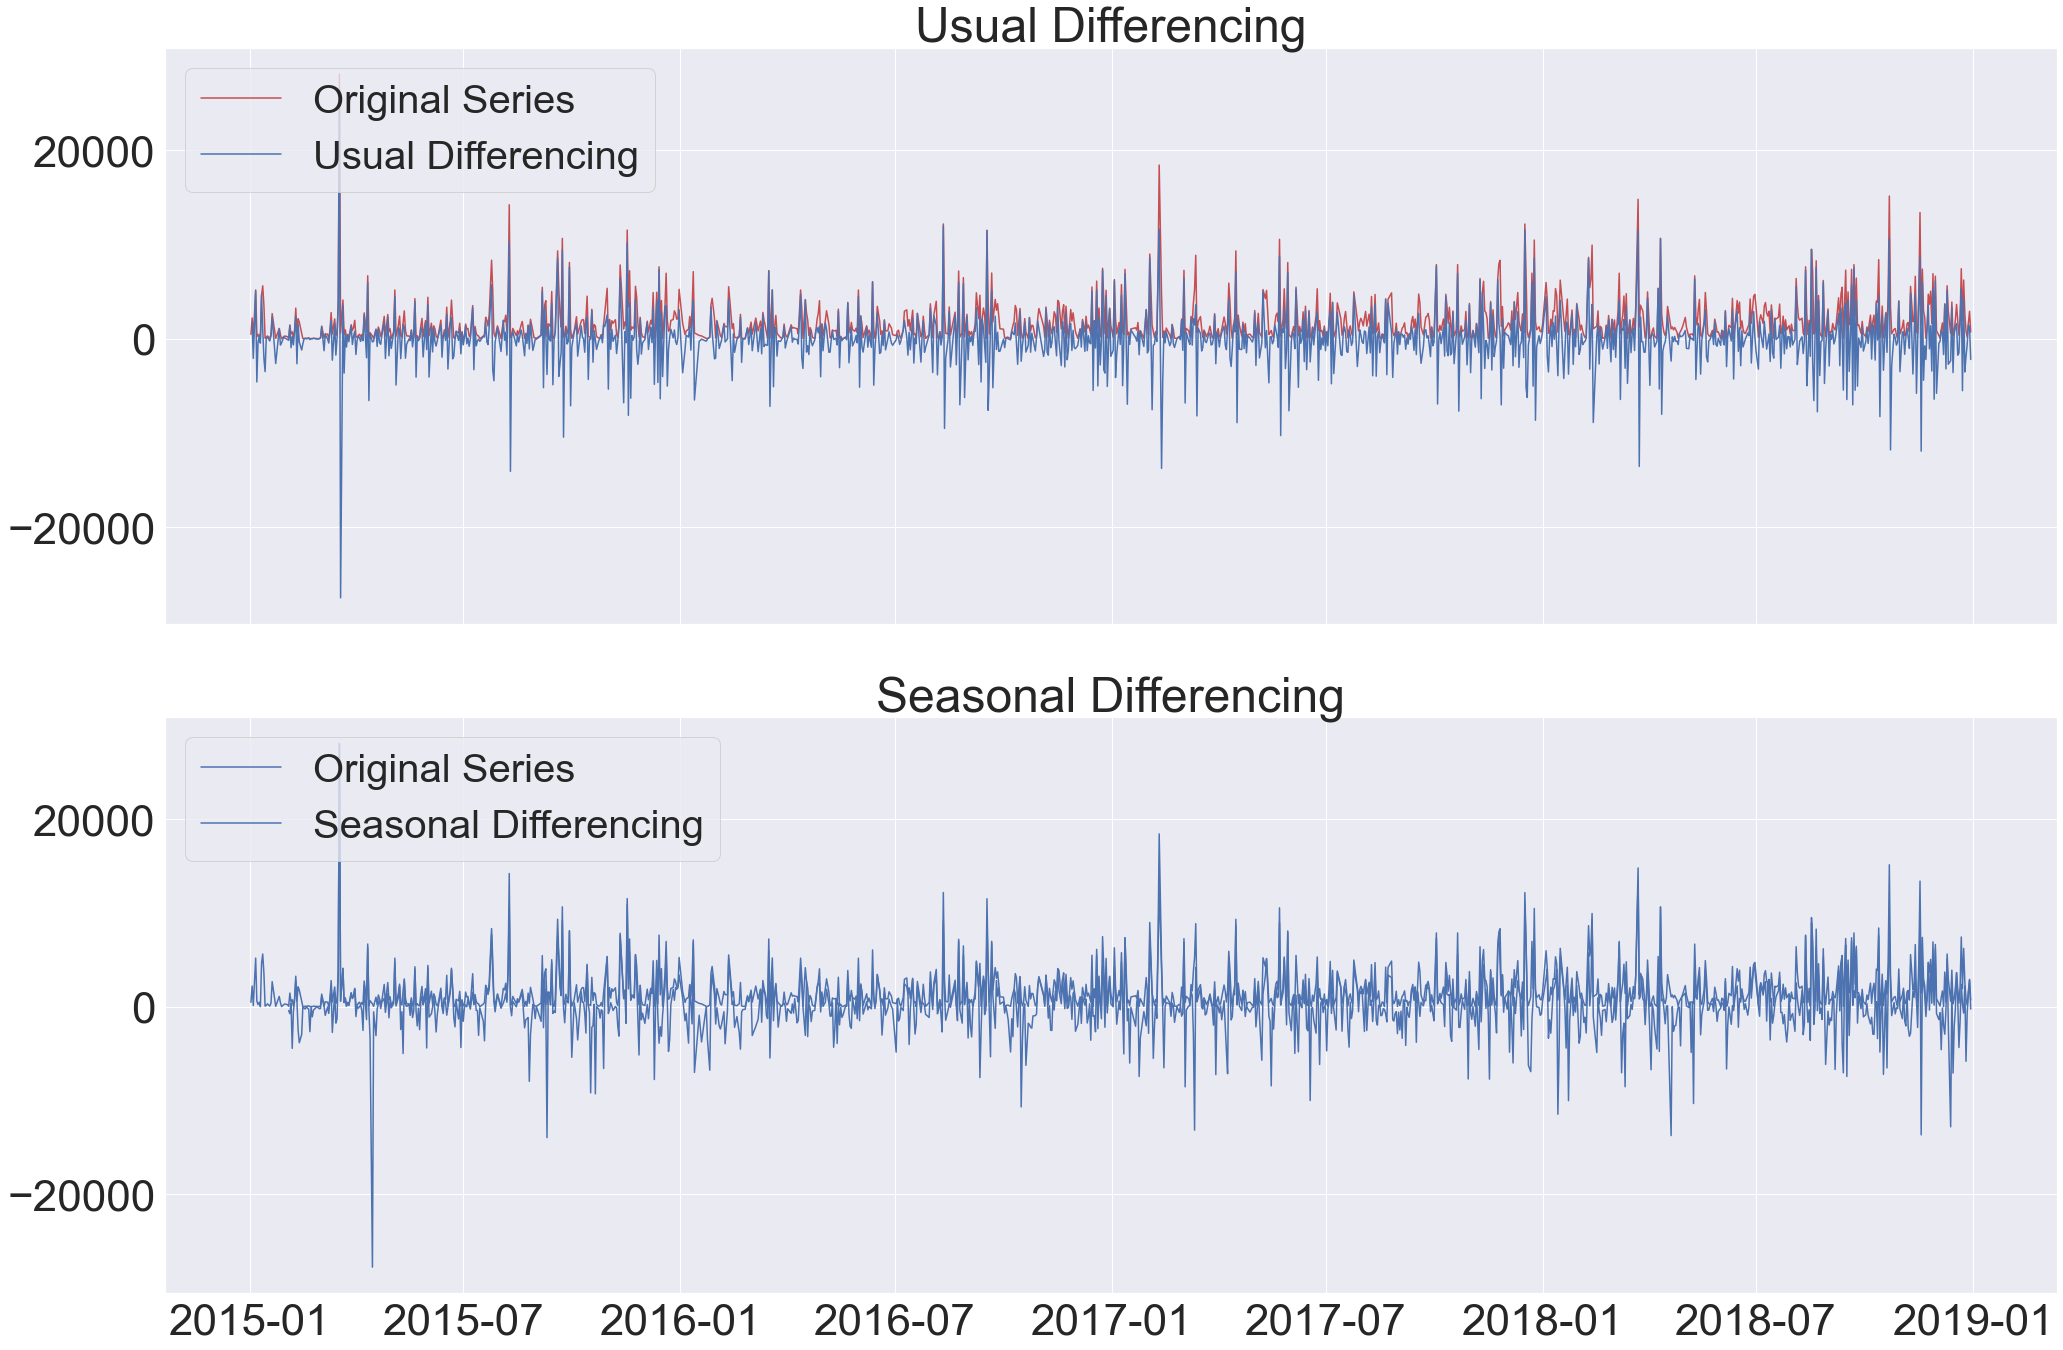

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(30,20), sharex=True)

# Usual Differencing
axes[0].plot(dfDailySales[:], label='Original Series',color='r')
axes[0].plot(dfDailySales[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=40)

# Seasonal Differencing
axes[1].plot(dfDailySales[:], label='Original Series')
axes[1].plot(dfDailySales[:].diff(24), label='Seasonal Differencing', color='b')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=40)

plt.tight_layout()
plt.show()

However, because the upward trend in the data is very insignificant, it is difficult to see the difference from the usual differencing and seasonal differencing, so we need to do the following analysis.

### ACF & PACF Plots

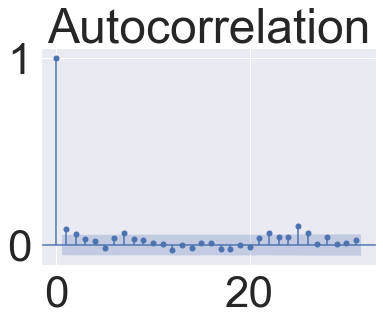

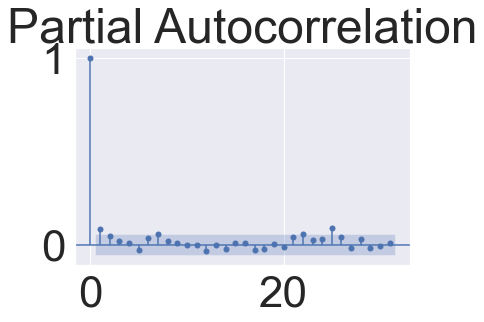

In [20]:
# Plot an ACF and PACF of our data.
plot_acf(dfDailySales['Sales'])
plt.show()
plot_pacf(dfDailySales['Sales'])
plt.show()

From the ACF and PACF graphs, we can see that both of them cut off at lag1 and lag25, but considering that all time series models require p+q to be as small as possible, so as to ensure the simplicity of the model, so we choose lag1 instead of lag25 in SARIMA Model.

### Building SARIMA Model
After the above analysis, we have determined the selection range of model parameters, where q=0 or 1, p=0 or 1, and d=1. So we also need to consider the value of AIC to determine the optimal SARIMA Model.

In [21]:
# Auto-ARIMA
lenData = len(dfDailySales)
dfTrain = dfDailySales[0:lenData-TEST_DAYS]
dfTest = dfDailySales[lenData-TEST_DAYS:lenData-EVAL_DAYS]
sarimaModel = pm.auto_arima(dfTrain, start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=25,
                         start_P=1, start_Q= 1, seasonal=True, 
                         max_P=1, max_Q=1,
                         d=1, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[25]             : AIC=inf, Time=9.83 sec
 ARIMA(0,1,0)(0,1,0)[25]             : AIC=22948.890, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[25]             : AIC=22339.569, Time=1.13 sec
 ARIMA(0,1,1)(0,1,1)[25]             : AIC=inf, Time=3.86 sec
 ARIMA(1,1,0)(0,1,0)[25]             : AIC=22623.701, Time=0.18 sec
 ARIMA(1,1,0)(1,1,1)[25]             : AIC=inf, Time=5.36 sec
 ARIMA(1,1,0)(0,1,1)[25]             : AIC=inf, Time=3.86 sec
 ARIMA(0,1,0)(1,1,0)[25]             : AIC=22612.816, Time=1.07 sec
 ARIMA(1,1,1)(1,1,0)[25]             : AIC=inf, Time=4.83 sec
 ARIMA(0,1,1)(1,1,0)[25]             : AIC=inf, Time=3.48 sec
 ARIMA(1,1,0)(1,1,0)[25] intercept   : AIC=22341.567, Time=1.31 sec

Best model:  ARIMA(1,1,0)(1,1,0)[25]          
Total fit time: 35.062 seconds


We need to find the smallest value of AIC to choose the best ARIMA Model, and in the result shown above, we can draw the conclusion that **SARIMAX(1, 1, 0)x(1, 1, 0, 25)** is the best model. It has AIC value of 22339.569, and all p-values are significant. 

### Fitting the Model

In [22]:
order=(1, 1, 0)
seasonalOrder = (1, 1, 0, 25)
model = SARIMAX(dfTrain, order=order, seasonal_order=seasonalOrder)

# fit the model
sarimaModel = model.fit()
print(sarimaModel.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30568D+00    |proj g|=  4.00752D-03


/Users/wangyanwen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wangyanwen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   6.463D-05   9.306D+00
  F =   9.3056538712073245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1200
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 25)   Log Likelihood              -11166.785
Date:                            Fri, 06 May 2022   AIC                          22339.569
Time:                                    11:42:32   BIC    

In the results of the ARIMA Model, we can see that the p-values of the autoregressive terms are all less than the significance level of 0.05, therefore, it can be concluded that the model is statistically significant and we can accept this model.

## Model Evaluation
In order to choose a better model to fit the original data, each model is evaluated and compared by its RMSE value.

### OLS

In [23]:
# Show RMSE and plot the data.
print(olsModel.summary())
olsPred = olsModel.predict(X_test)
print('\n*****Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, olsPred)))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.536
Date:                Fri, 06 May 2022   Prob (F-statistic):           8.71e-07
Time:                        11:42:32   Log-Likelihood:                -10372.
No. Observations:                1140   AIC:                         2.075e+04
Df Residuals:                    1135   BIC:                         2.078e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1274.6576    119.516     10.665      0.0

**RMSE** of the OLS model is **1959.1419.**

#### 15-Day Predictions

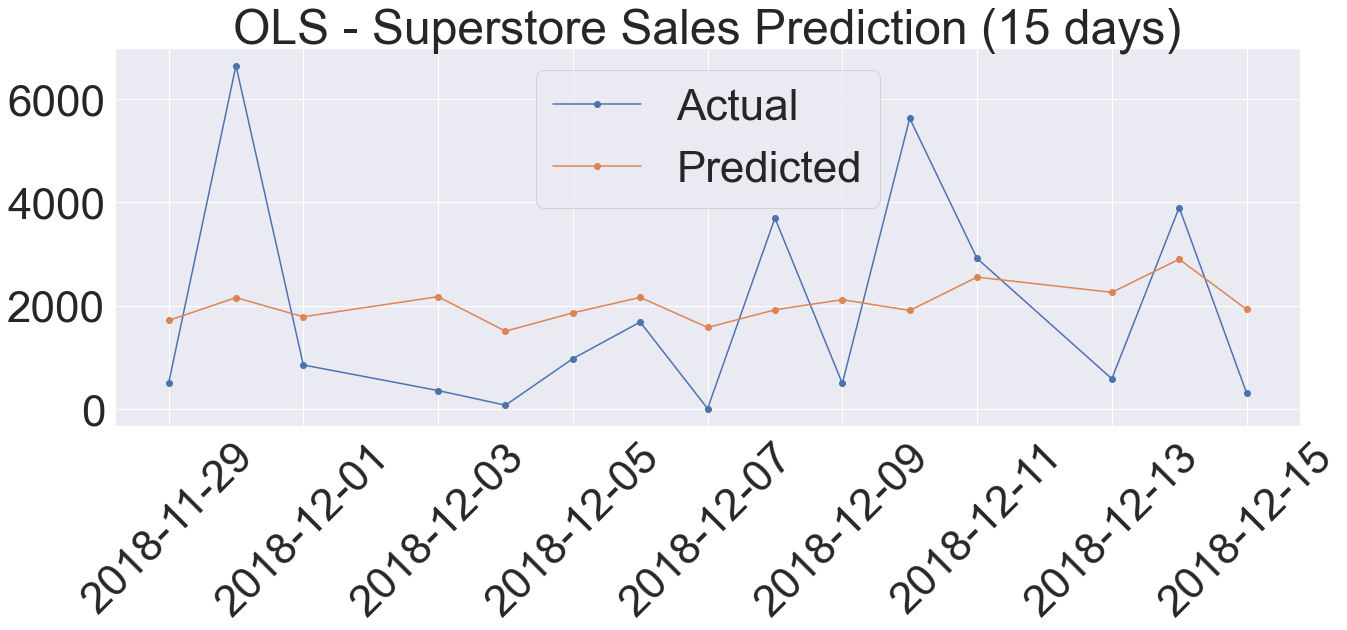

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(olsPred, label='Predicted', marker='o')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title("OLS - Superstore Sales Prediction (15 days)")
plt.tight_layout()
plt.show()

Aside from the magnitude of the fluctuation, we can still see that the predicted value and the actual value have some similarities in trend. But overall, the fluctuation of the predicted value is very small, and they are all shaking around the average value of the data, so It is difficult to predict some extreme values.

### SARIMA

In [25]:
print(sarimaModel.summary())

# get the predictions and residuals
sarimaPred = sarimaModel.forecast(len(dfTest))
sarimaPred.index = dfTest.index
mse = mean_squared_error(sarimaPred, dfTest['Sales'])
rmse = np.sqrt(mse)
print(f"\n*****RMSE: {rmse}")

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1200
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 25)   Log Likelihood              -11166.785
Date:                            Fri, 06 May 2022   AIC                          22339.569
Time:                                    11:42:32   BIC                          22354.774
Sample:                                         0   HQIC                         22345.303
                                           - 1200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4869      0.020    -23.857      0.000      -0.527      -0.447
ar.S.L25      -0.5030      0.020   

/Users/wangyanwen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


**RMSE** of the SARIMA model is **5803.6780.**

#### 15-Day Predictions

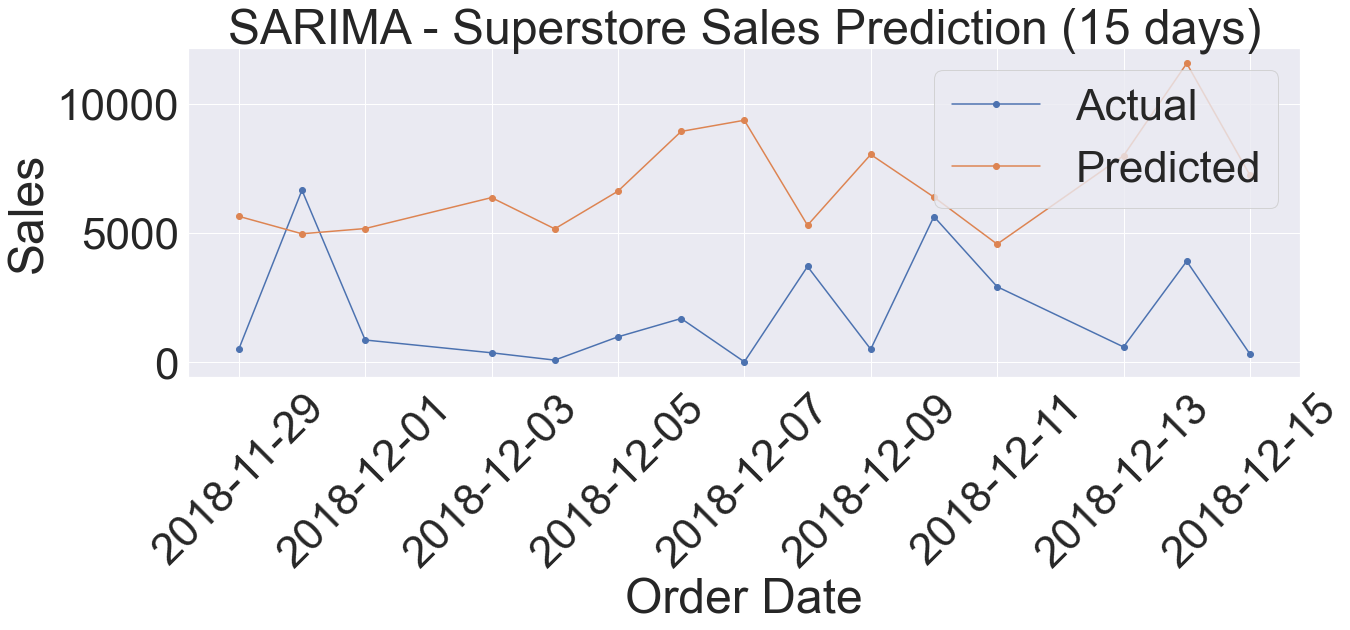

In [26]:
orderTime = dfTest.index
plt.figure(figsize=(20, 10))
plt.plot(orderTime, dfTest['Sales'], label="Actual", marker='o')
plt.plot(orderTime, sarimaPred, label="Predicted", marker='o')
plt.xticks(rotation=45)
plt.legend(loc = "best")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.title("SARIMA - Superstore Sales Prediction (15 days)")
plt.tight_layout()
plt.show()

In the SARIMA Model, although the predicted value of the fluctuation range is similar to the real value, the curve of the predicted value is almost always above the real value, which is obviously overestimated. Therefore, the prediction is not so accurate.

### Model Comparison
The table below shows RMSE values of two models.

| Model | RMSE |
| --- | --- |
| OLS |1959.1419| 
| SARIMA | 5803.678|

We need to judge the quality of the model based on the RMSE values of the two models and the deviation between its predicted value and the actual value. To be on the safe side, the predicted value of OLS is more stable, fluctuating around the average value of the actual value, and at the same time the **OLS** model has the lowest RMSE value. Therefore, we choose OLS Model as our best model.

## Future Predictions

Using the selected best model, we can make a t+1 prediction from the most current observed data.

In [27]:
NUM_PREDICTION_DAY = 1

In [28]:
def addPredicitionDate(df, n):
    """
    Add the prediction date to the original dataset.
    :param df: dataset
    :param n: number of time step to shift front.
    :return: new dataset with t+n dates as index.
    """
    rowNum = df.shape[0]
    lastDate = df.index[rowNum-1]

    dateIndex = []
    for i in range(n) :
        tPlus1Date = lastDate + datetime.timedelta(days=1)
        dateIndex.append(tPlus1Date)
        lastDate = tPlus1Date

    dfForPrediction = dfDailySales.copy()

    for date in dateIndex:
        dfForPrediction.loc[date] = None

    return dfForPrediction

In [29]:
# add t+1 date to the original dataset
dfTPlus1 = addPredicitionDate(dfSales, NUM_PREDICTION_DAY)
dfTPlus1Prepared = prepareDf(dfTPlus1, ["Sales"])

# preprocess future data to put it into ols model.
futureX = dfTPlus1Prepared.iloc[-NUM_PREDICTION_DAY].to_frame().T
futureX = futureX[sigFeaturesLi]
futureX = sm.add_constant(futureX, has_constant='add')

/Users/wangyanwen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
# predict
validationPred = olsModel.predict(stack_X_test)
futurePred = olsModel.predict(futureX)
# convert array to series with a timeseries index
validationPred = pd.Series(validationPred)
validationPred.index = stack_y_test.index
print(f"\n*****\tRMSE of the validation set is {mean_squared_error(stack_y_test, validationPred, squared=False)}")

futurePred = pd.Series(futurePred)
futurePred.index = futureX.index
validationPred = pd.concat([validationPred, futurePred])

print(f"\n*****\tSales prediction for {futurePred.index[0]} is {futurePred.values[0]}")


*****	RMSE of the validation set is 1902.4037035489287

*****	Sales prediction for 2018-12-31 00:00:00 is 2249.0915456878083


### Final Prediction

From the above operation we can see that the RMSE of the OLS model is 1902.40. The estimated value of our estimated t+1 is the next day after the most recent date in the data set, that is, our estimated sales forecast for December 31, 2018 is 2249.09.

In the following section we will show a visual representation of these predictions for the future.

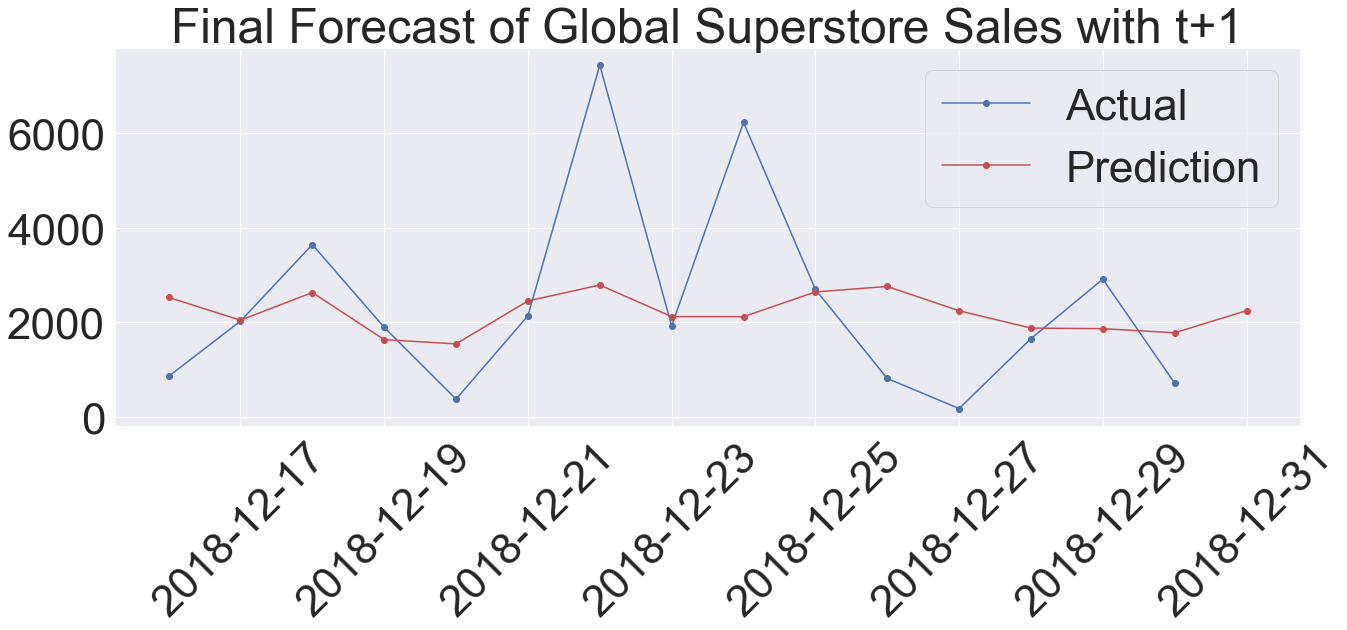

In [31]:
# plot forecast along with 15 day validation data
indexForecast = pd.date_range(dfDailySales.index[-EVAL_DAYS], periods=EVAL_DAYS + 1, freq = 'D')
actualSeries = pd.Series(stack_y_test, index=indexForecast)
validationSeries = pd.Series(validationPred, index=indexForecast)


plt.figure(figsize=(20, 10))
plt.plot(actualSeries, color="b", label="Actual", marker='o')
plt.plot(validationSeries, color="r", label="Prediction", marker='o')
plt.title("Final Forecast of Global Superstore Sales with t+1")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Finding

Before conducting the modeling, we analyzed the data to obtain the five cities with the highest sales volume, and after conducting the modeling, we may find that the largest share of total sales is still in these five cities. Our model predicts a slow growth trend in total sales, and at the peak of growth may be somewhat different from the actual sales. The OLS model is the most accurate model that we have compared to predict our target problem.

It's difficult to deal with data that portraits high seasonality. Because there were multiple rows that have the same order date. Aggregating and summing all the sales up for the same order date made all the other columns useless that could potentially become other predictor variables.
  
If we have the opportunity to further improve our model, we can combine the two models and consider some exogenous factors together, such as changes in the economic environment, the impact of epidemics, changes in natural weather, etc., all of which may affect the change in our total sales
     

In [32]:
# OLS Robust refression model

olsModel1 = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())

olsModel1_results = rlm_model.fit()

print(rlm_results.summary())

NameError: name 'rlm_model' is not defined

Are your findings robust to different model specifications?
After comparing the results of OLS model and robust regression, we found that the coefficients of all variables were significant at the 95% confidence level, and there were few outlines in data analysis, so the regression was robust in OLS model

In [ ]:
# SARIMA Robust refression model

model1 = SARIMAX(dfTrain, order=order, seasonal_order=seasonalOrder,robust=True)

# fit the model
sarimaModel1 = model.fit()
print(sarimaModel1.summary())

Regarding the robustness of the SARIMA model, we went back to the previous part of the data description and found that outliers were relatively few, and we had already proposed these values when processing the data. At the same time, we found that the p-values of all coefficients in the two models were 0.01 , so the regression of the SARIMA model is also robust.
In summary, there is no correlation between the two models.

# 5. Conclusion

Through time series analysis,  we could graph and forecast the the sales of super stores. With the various data spread in diferent county and region, we could draw the portrait of customers of the super stores and provide with information for owners to make operation analysis and desicions. 

In order to better improve the operation of the supermarket and have enough storage, we decided to use model regression to quantitatively analyze the data set. Based on the knowledge we have learned, we constructed the OLS model and the SARIMA model respectively, and tested their fitting effects. Although Both of them are not particularly good in data fitting, but from the perspective of long-term operation of supermarkets, we finally chose the OLS model from the perspective of stable prediction.

Of course for future research, seasonal factors should be taken into consideration to make a better forecast. Also, we can use a stack model, which is a combination of the two models and consider some exogenous factors together. To improve the fit of the model Effect.